# Understanding learning curves

Now that you’ve learned how to implement fine-tuning using both the `Trainer` API and custom training loops, it’s crucial to understand how to interpret the results. Learning curves are invaluable tools that help you evaluate your model’s performance during training and identify potential issues before they reduce performance.



In this section, we’ll explore how to read and interpret accuracy and loss curves, understand what different curve shapes tell us about our model’s behavior, and learn how to address common training issues.



## 1. Examples of tracking loss curves

In [1]:
# Install Pytorch & other libraries
%pip install -qqq torch torchvision setuptools scikit-learn

# Install Hugging Face libraries
%pip install  --upgrade datasets -qqq accelerate hf-transfer transformers

In [2]:
from datasets import load_dataset

dataset_id = "burtenshaw/PleIAs_common_corpus_code_classification"
dataset = load_dataset(dataset_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/418 [00:00<?, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/94.9M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/94.5M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/20.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/127723 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/14192 [00:00<?, ? examples/s]

In [3]:
print(len(dataset["train"]))
print(dataset)
print(dataset["train"][:2])

127723
DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 127723
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 14192
    })
})
{'text': ['/*\n * Copyright (c) 2000 Kungliga Tekniska Högskolan\n * (Royal Institute of Technology, Stockholm, Sweden).\n * All rights reserved.\n *\n * Redistribution and use in source and binary forms, with or without\n * modification, are permitted provided that the following conditions\n * are met:\n *\n * 1. Redistributions of source code must retain the above copyright\n *    notice, this list of conditions and the following disclaimer.\n *\n * 2. Redistributions in binary form must reproduce the above copyright\n *    notice, this list of conditions and the following disclaimer in the\n *    documentation and/or other materials provided with the distribution.\n *\n * 3. Neither the name of the Institute nor the names of its contributors\n *    may be used to endorse or promote 

In [4]:
print(dataset["train"][0])

{'text': '/*\n * Copyright (c) 2000 Kungliga Tekniska Högskolan\n * (Royal Institute of Technology, Stockholm, Sweden).\n * All rights reserved.\n *\n * Redistribution and use in source and binary forms, with or without\n * modification, are permitted provided that the following conditions\n * are met:\n *\n * 1. Redistributions of source code must retain the above copyright\n *    notice, this list of conditions and the following disclaimer.\n *\n * 2. Redistributions in binary form must reproduce the above copyright\n *    notice, this list of conditions and the following disclaimer in the\n *    documentation and/or other materials provided with the distribution.\n *\n * 3. Neither the name of the Institute nor the names of its contributors\n *    may be used to endorse or promote products derived from this software\n *    without specific prior written permission.\n *\n * THIS SOFTWARE IS PROVIDED BY THE INSTITUTE AND CONTRIBUTORS ``AS IS\'\' AND\n * ANY EXPRESS OR IMPLIED WARRANTI

In [5]:
from transformers import AutoTokenizer, DataCollatorWithPadding

model_id = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize_func(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True, remove_columns=["text"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/127723 [00:00<?, ? examples/s]

Map:   0%|          | 0/14192 [00:00<?, ? examples/s]

In [6]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 127723
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 14192
    })
})

In [7]:
tokenized_dataset["train"]

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 127723
})

In [8]:
tokenized_dataset["train"].features.keys()

dict_keys(['labels', 'input_ids', 'token_type_ids', 'attention_mask'])

In [9]:
from transformers import AutoModelForSequenceClassification

all_labels = set()
for split in tokenized_dataset.keys():
    all_labels.update(tokenized_dataset[split]["labels"])

unique_labels = list(all_labels)
num_labels = len(unique_labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(unique_labels):
    id2label[i] = label
    label2id[label] = i

model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    id2label=id2label,
    label2id=label2id
)

def encode_labels(batch):
    return {"labels": [label2id[label] for label in batch["labels"]]}

tokenized_dataset = tokenized_dataset.map(encode_labels, batched=True)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Map:   0%|          | 0/127723 [00:00<?, ? examples/s]

Map:   0%|          | 0/14192 [00:00<?, ? examples/s]

In [10]:
print(unique_labels)

['Visual Basic', 'ColdFusion', 'Starlark', 'Fish', 'Lean', 'Fortran Free Form', 'Thrift', 'RDoc', 'Inno Setup', 'FreeBasic', 'Go', 'Unity3D Asset', 'Dockerfile', 'KiCad Layout', 'Scilab', 'Wavefront Object', 'Logtalk', 'Dart', 'J', 'PureScript', 'Ada', 'Unix Assembly', 'JQ', 'Gradle', 'Graphviz (DOT)', 'Gettext Catalog', 'HTML+Razor', 'POV-Ray SDL', 'Hack', 'MATLAB', 'Swift', 'Adobe Font Metrics', 'AGS Script', 'Ioke', 'ApacheConf', 'PicoLisp', 'ImageJ Macro', 'Redcode', 'Rascal', 'GAS', 'Inform 7', 'GLSL', 'Julia', 'OpenType Feature File', 'Gherkin', 'PHP', 'Less', 'REALbasic', 'Haskell', 'JavaScript', 'GDScript', 'Perl', 'ObjDump', 'Isabelle', 'Ragel in Ruby Host', 'XS', 'GDB', 'Kit', 'Scala', 'Vim Script', 'Verilog', 'Nim', 'Ignore List', 'FreeMarker', 'Metal', 'Sass', 'OCaml', 'Turtle', 'XML Property List', 'Python', 'Gerber Image', 'Java', 'Prolog', 'Lua', 'Twig', 'PowerShell', 'Pascal', 'Raw token data', 'Apex', 'Hoon', 'Visual Basic .NET', 'Solidity', 'Objective-C', 'TSV', 'R', 

In [11]:
print("Sample labels:")
print(tokenized_dataset["train"]["labels"][:5])
print(type(tokenized_dataset["train"]["labels"][0]))
print(tokenized_dataset["train"].column_names)

Sample labels:
[124, 143, 69, 106, 45]
<class 'int'>
['labels', 'input_ids', 'token_type_ids', 'attention_mask']


In [12]:
import numpy as np
from sklearn.metrics import f1_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)
    score = f1_score(labels, predictions, labels=unique_labels, average='weighted')
    return {"f1": float(score)}

In [13]:
model.config.pad_token_id = tokenizer.pad_token_type_id
model.config.bos_token_id = tokenizer.bos_token_id
model.config.eos_token_id = tokenizer.eos_token_id

In [15]:
from huggingface_hub import login
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import wandb

# Login to Hugging Face
login()

wandb.init(
    project='transformer-fine-tuning', name='undefined'
)

training_args = TrainingArguments(
    output_dir="ModernBERT-classifier",
    per_device_eval_batch_size=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    num_train_epochs=10,
    bf16=True,
    optim="adamw_torch_fused",     # improved version of AdamW for GPU
    logging_strategy="steps",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    push_to_hub=True,
    hub_strategy="every_save",
    report_to="wandb",
    gradient_checkpointing=True 
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    processing_class=tokenizer,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [16]:
model.gradient_checkpointing_enable()

In [ ]:
trainer.train()

## 2. Practical Examples


### 2.1. Overfitting

#### Symptoms:
* Training loss continues to decrease while validation loss increases or plateaus

* Large gap between training and validation accuracy

* Training accuracy much higher than validation accuracy

#### Solutions for overfitting:



* Regularization: Add dropout, weight decay, or other regularization techniques

* Early stopping: Stop training when validation performance stops improving

* Data augmentation: Increase training data diversity

* Reduce model complexity: Use a smaller model or fewer parameters

### 2.2. Underfitting


Underfitting occurs when the model is too simple to capture the underlying patterns in the data. This can happen for several reasons:

* The model is too small or lacks capacity to learn the patterns

* The learning rate is too low, causing slow learning

* The dataset is too small or not representative of the problem

* The model is not properly regularized

#### Symptoms:

* Both training and validation loss remain high

* Model performance plateaus early in training

* Training accuracy is lower than expected

#### Solutions for underfitting:



* Increase model capacity: Use a larger model or more parameters

* Train longer: Increase the number of epochs

* Adjust learning rate: Try different learning rates

* Check data quality: Ensure your data is properly preprocessed

### 2.3. Erratic Learning Curves


Erratic learning curves occur when the model is not learning effectively. This can happen for several reasons:

* The learning rate is too high, causing the model to overshoot the optimal parameters

* The batch size is too small, causing the model to learn slowly

* The model is not properly regularized, causing it to overfit to the training data

* The dataset is not properly preprocessed, causing the model to learn from noise

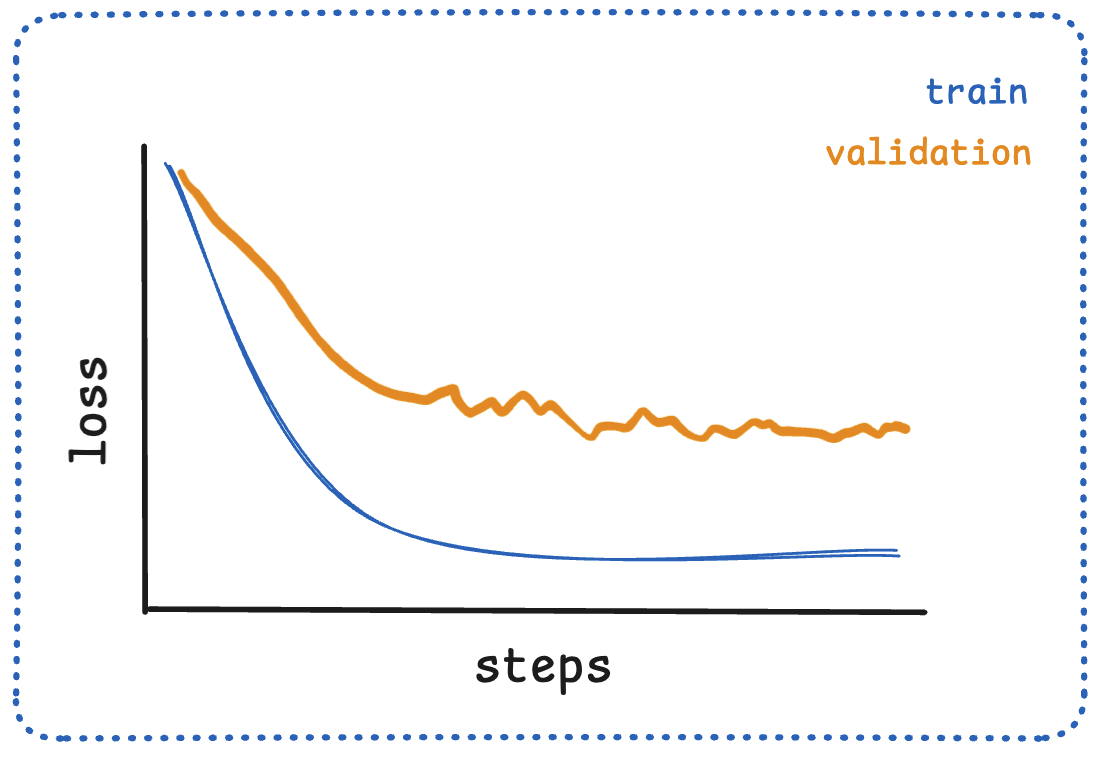

#### Symptoms:

* Frequent fluctuations in loss or accuracy

* Curves show high variance or instability

* Performance oscillates without clear trend

#### Solutions for erratic curves:



* Lower learning rate: Reduce step size for more stable training

* Increase batch size: Larger batches provide more stable gradients

* Gradient clipping: Prevent exploding gradients

* Better data preprocessing: Ensure consistent data quality